# 1 Development of phase-flip error correcting circuit

In [1]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import Initialize
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel,pauli_error
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeBogotaV2, FakeGuadalupeV2, FakeVigoV2, FakeAuckland,FakePerth
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace, DensityMatrix, random_statevector
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
simulator_aer=AerSimulator()

Initiation, step 0 yields the state |00000> (|q4q3q2q1q0>), where q4 and q3 are the parities.

In [2]:
qr = QuantumRegister(5, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc.save_statevector(label="step_0")

This cell, including steps 1 and 2  has the objective of having as output: $$\alpha\ket{+++}+\beta\ket{---}$$

In order to do this, I introduced a gate which initializes the first qubit from |0> to $\psi=\alpha\ket{0}+\beta\ket{1}$ . Therefore, step 1 yields $$\alpha\ket{00000}+\beta\ket{00001}$$
This is fine considering the first two are the ancilla qubits.
If we apply two CNOT gates, both using q0 as control and q1 and q2 as targets(step 2) we can see that we get the state $\psi=\alpha\ket{000}+\beta\ket{111}$

At the end, we apply hadamard gates to transform the state to $\alpha\ket{+++}+\beta\ket{---}$

In [3]:
alpha=beta=1/np.sqrt(2)
psi = [alpha, beta]
init_gate=Initialize(psi)
qc.append(init_gate, [0])
qc.save_statevector(label="step_1")

qc.cx(0, 1)  
qc.cx(0, 2)  

qc.h(0)
qc.h(1)
qc.h(2)

qc.save_statevector(label="step_2")

Step 3 consists in the first part of the quantum correction circuit. It should yield the parities stored in q4 and q3 along with the rest of the qubits, and is identical to that of the bitflip code apart from the hadamard gates being applied both before and after the correction cnots as well as the z gate being applied.

In [4]:
#CNOT and H gates
#I applied a Z gate on the third qubit of the triplet as an example of error
qc.z(2)

qc.h(0)
qc.h(1)
qc.h(2)

qc.save_statevector(label="step_3")

qc.cx(0, 3)
qc.cx(1, 3)

qc.cx(1, 4)
qc.cx(2, 4)

qc.save_statevector(label="step_4")

qc.h(0)
qc.h(1)
qc.h(2)

qc.save_statevector(label="step_5")

#Ancillas:
qc.measure(3, 0) #clbit[0]
qc.measure(4, 1) #clbit[1]




Step 4 was a little tricky. Given that I couldn't find a way to apply Z using several conditions (with c_if) I used the fact that qiskit keeps the classical bits in a register or list, therefore I can use the decimal value of each of the combinations to know the value of the ancillas.

| Ancilla 0 | Ancilla 1 | Register | Decimal | Action|
| --- | --- | --- | --- | --- |
| 0 | 0 | 00 |0| N/A |
| 0 | 1 | 01 |1|Z to q2 |
| 1 | 0 | 10 |2|Z to q0|
| 1 | 1 | 11 |3|Z to q1|

Note that, here I am defining the ancilla register as q4q5, and therefore is in the opposite order as in the results I obtain.
With this, the phase-flip error correction code is complete

In [5]:
qc.z(0).c_if(cr, 1) 
qc.z(1).c_if(cr, 3) 
qc.z(2).c_if(cr, 2)  

qc.save_statevector(label="step_6")

Now, we need to revert back to the original state. Right now we have $\alpha\ket{+++}+\beta\ket{---}$ but we actually want $\psi=\alpha\ket{000}+\beta\ket{001}$, since this way we can separate the two auxiliary qubits we used to encode the initial $\psi=\alpha\ket{0}+\beta\ket{1}$ state:

In [6]:
qc.h(0)
qc.h(1)
qc.h(2)
qc.cx(0,2)
qc.cx(0,1)
qc.save_statevector(label="step_7")

Step 6 is just applying the inverse of the initialize gate in order to obtain all 0s again (the ancillas may be changed ofc, the main point is that we should always measure 0 in the first qubit at this step)

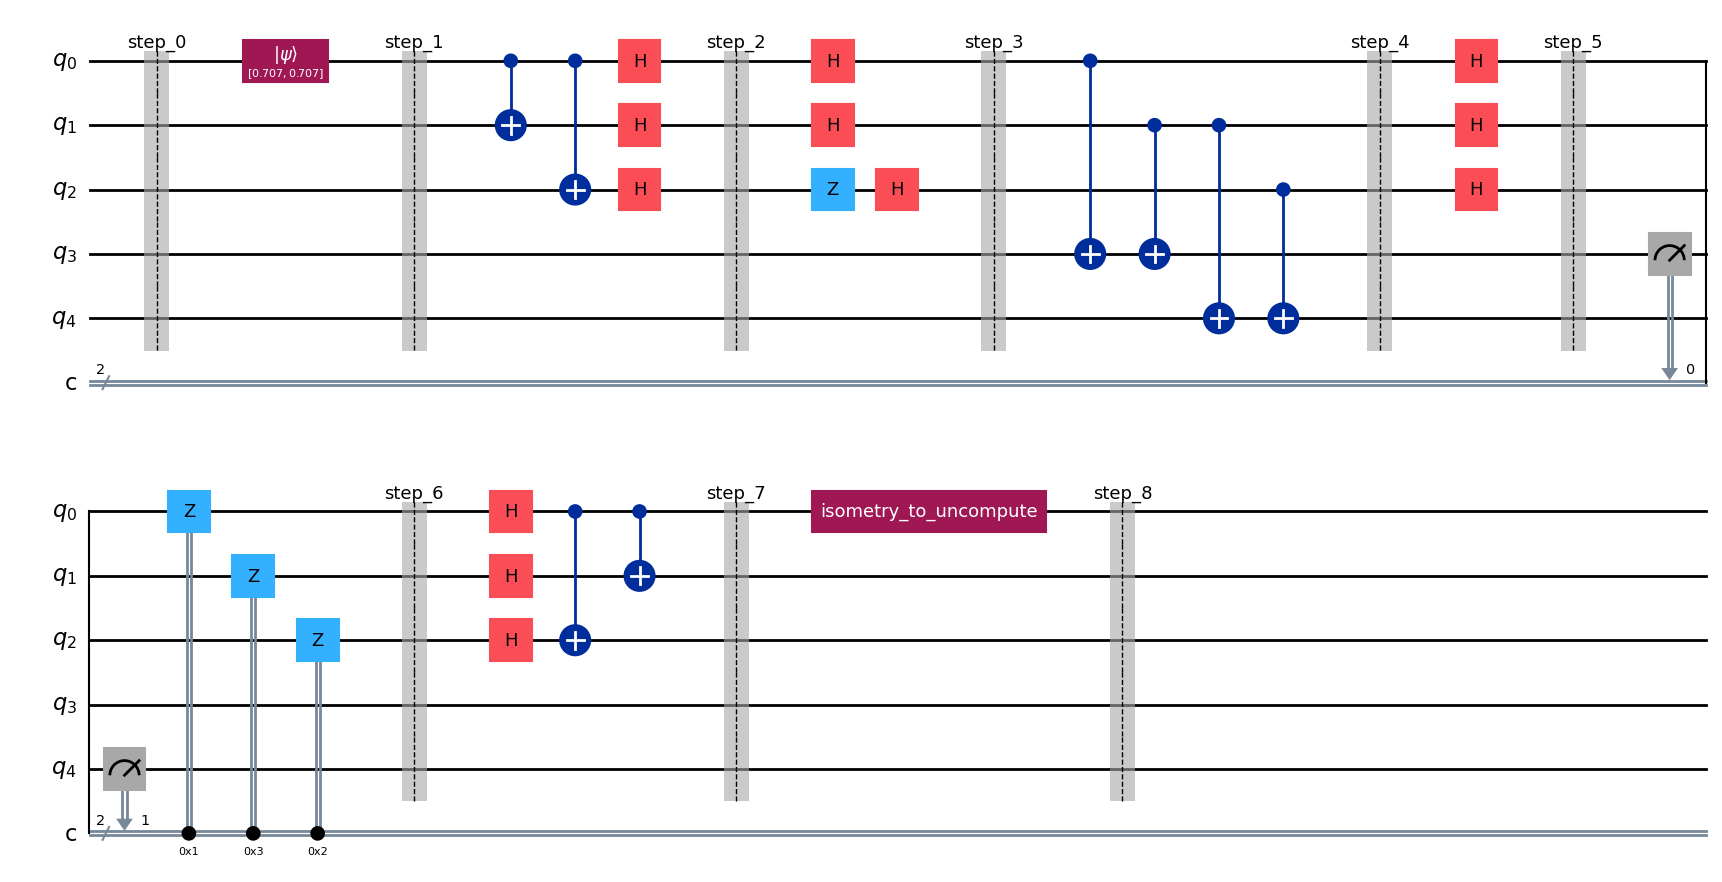

In [7]:
qc.append(init_gate.gates_to_uncompute(), [0])
qc.save_statevector(label="step_8")

qc.draw('mpl')

This next cells are to control how the state evolves in the different steps. Remember that this code gives the result as: $$\ket{q_4 q_3 q_2 q_1 q_0}$$

In [8]:
qc_aer=transpile(qc,backend=simulator_aer)

result= simulator_aer.run(qc_aer).result()

state_0 = result.data()["step_0"]
state_1 = result.data()["step_1"]
state_2 = result.data()["step_2"]
state_3 = result.data()["step_3"]
state_4 = result.data()["step_4"]
state_5 = result.data()["step_5"]
state_6 = result.data()["step_6"]
state_7 = result.data()["step_7"]
state_8 = result.data()["step_8"]

In [9]:
states = [state_0, state_1, state_2, state_3, state_4, state_5, state_6, state_7, state_8]

for i, state in enumerate(states, 1):
    print(f"Step {i-1}:")
    display(state.draw("latex"))

Step 0:


<IPython.core.display.Latex object>

Step 1:


<IPython.core.display.Latex object>

Step 2:


<IPython.core.display.Latex object>

Step 3:


<IPython.core.display.Latex object>

Step 4:


<IPython.core.display.Latex object>

Step 5:


<IPython.core.display.Latex object>

Step 6:


<IPython.core.display.Latex object>

Step 7:


<IPython.core.display.Latex object>

Step 8:


<IPython.core.display.Latex object>

The state is correctly retrieved, and the ancilla register tells us the position of the error (third qubit)

# 2. Simulations with fake provider
Suppose an initial state α |0⟩ + β |1⟩ (assigned for the first qubit), apply 1 sequence of QEC, and check if the state is correct after. For this, it is easier to define a function which does the same as the code above, in order to be able to average over different runs. For this, I implemented a function to run a circuit, specifying whether there is noise or not:

In [10]:
def run_fake(qc,device_backend,noise_model=None,Nshots=1024,optim=0):
    """
    Function that runs a given quantum circuit in the specified backend with/without noise and using Nshots
    
    Args:
        QuantumCircuit (with measurements)
        device_backend(provider)
        noise_model(True or None); by default None (without noise)
        Nshots(integer); by default 1024 shots
        Optim(integer,0,1,2): optimization level for transpilation, by default 0
        
    Returns:
        Transpiled QuantumCircuit
        counts(dictionary)
    """
    sim_faked = AerSimulator.from_backend(device_backend)
    qc_transpiled = transpile(qc, device_backend,optimization_level=optim) 
    if noise_model == True: #to make the difference explicit 
        result = sim_faked.run(qc_transpiled,shots=Nshots).result()
    else: 
        result = sim_faked.run(qc_transpiled,shots=Nshots,noise_model=None).result()
    counts = result.get_counts()

    return qc_transpiled,counts

Now, I created a function that actually runs the circuit I coded before:

In [11]:
def phaseflip_error_correction(psi, device_backend, noise_model=None, Nshots=1024, optim=0):
    qr = QuantumRegister(5, "q")
    cr = ClassicalRegister(2, "c") #for ancillas
    cr2 = ClassicalRegister(1, "c_main") #for final state
    qc = QuantumCircuit(qr, cr, cr2)
    # Step 0
    init_gate=Initialize(psi)
    qc.append(init_gate, [0])
    # Step 1
    qc.cx(0, 1)
    qc.cx(0, 2)
    # Step 2
    qc.h(0)
    qc.h(1)
    qc.h(2)

    #phaseflip errors here
    qc.z(2)

    qc.h(0)
    qc.h(1)
    qc.h(2)

    qc.cx(0, 3)
    qc.cx(1, 3)
    qc.cx(1, 4)
    qc.cx(2, 4)

    qc.h(0)
    qc.h(1)
    qc.h(2)

    qc.measure(3, cr[0])
    qc.measure(4, cr[1])
    # Step 3
    qc.z(0).c_if(cr, 1)
    qc.z(1).c_if(cr, 3)
    qc.z(2).c_if(cr, 2)
    # Step 4
    
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.cx(0, 2)
    qc.cx(0, 1)
    # Step 5:
    qc.append(init_gate.gates_to_uncompute(), [0])
    #extra step done to measure the first qubit after error correction
    qc.measure(0, cr2[0])

    # Step 6
    qc_transpiled, counts = run_fake(qc, device_backend, noise_model, Nshots, optim)

    return qc_transpiled, counts


alpha = np.sqrt(0.5)
beta = np.sqrt(0.5)
psi=[alpha, beta]

qc_transpiled, counts = phaseflip_error_correction(psi, FakeBogotaV2(), Nshots=1024, optim=0)

print(counts)


{'0 10': 1024}


Next step is to apply Z gates manually and see the performance of the quantum correction circuit. Fidelity is just the probability of obtaining 0.

The next function is used to evaluate performance of the correction circuit code. It uses a random state for each num_trial and runs the circuit. Note that this function does not take into account any of the parameters defined before for running the circuit, you have to plug them in manually when calling phaseflip_error_correction (which is an input).
This function returns the counts, probabilities of success and for each outcome, and the total fidelity for the circuit for each of the num_trials. They will be in the form  'State 1': {'0 01': 1024} where the first element is the state after measurement, and the two together are the measurements for the ancilla

In [12]:
def evaluate_performance(q_circuit,num_trials=10):
    all_counts = {}
    probabilities = {}  
    probabilities_0 = {}  

    possible_combinations = [f"{i} {j:02b}" for i in range(2) for j in range(4)]  # ["0 00", "0 01", ..., "1 11"]
    for i in range(num_trials):
        psi=random_statevector(2)
        qc_transpiled, counts = q_circuit(psi, FakePerth(), Nshots=1024, optim=0)
        all_counts[f"State {i+1}"] = counts
        total_shots = sum(counts.values())  # Total of values
        state_probabilities = {}  # Store probabilities for each
        prob_0 = 0 #initialize

        for comb in possible_combinations:
            state_probabilities[comb] = counts.get(comb, 0) / total_shots  # Probability of each combination for a single state
            if comb.startswith("0"):
                prob_0 += state_probabilities[comb]  # Acumulamos si empieza con 0

        probabilities[f"State {i+1}"] = state_probabilities  # Save that state's probabilities in the bigger dictionary
        probabilities_0[f"State {i+1}"] = prob_0  
    fidelity =sum(probabilities_0.values()) / num_trials

    return all_counts, probabilities, probabilities_0, fidelity

data, probabilities, probabilities_0, fidelity =evaluate_performance(phaseflip_error_correction)  

print(probabilities)
print(probabilities_0)
print(fidelity)

 

{'State 1': {'0 00': 0.0, '0 01': 0.0, '0 10': 1.0, '0 11': 0.0, '1 00': 0.0, '1 01': 0.0, '1 10': 0.0, '1 11': 0.0}, 'State 2': {'0 00': 0.0, '0 01': 0.0, '0 10': 1.0, '0 11': 0.0, '1 00': 0.0, '1 01': 0.0, '1 10': 0.0, '1 11': 0.0}, 'State 3': {'0 00': 0.0, '0 01': 0.0, '0 10': 1.0, '0 11': 0.0, '1 00': 0.0, '1 01': 0.0, '1 10': 0.0, '1 11': 0.0}, 'State 4': {'0 00': 0.0, '0 01': 0.0, '0 10': 1.0, '0 11': 0.0, '1 00': 0.0, '1 01': 0.0, '1 10': 0.0, '1 11': 0.0}, 'State 5': {'0 00': 0.0, '0 01': 0.0, '0 10': 1.0, '0 11': 0.0, '1 00': 0.0, '1 01': 0.0, '1 10': 0.0, '1 11': 0.0}, 'State 6': {'0 00': 0.0, '0 01': 0.0, '0 10': 1.0, '0 11': 0.0, '1 00': 0.0, '1 01': 0.0, '1 10': 0.0, '1 11': 0.0}, 'State 7': {'0 00': 0.0, '0 01': 0.0, '0 10': 1.0, '0 11': 0.0, '1 00': 0.0, '1 01': 0.0, '1 10': 0.0, '1 11': 0.0}, 'State 8': {'0 00': 0.0, '0 01': 0.0, '0 10': 1.0, '0 11': 0.0, '1 00': 0.0, '1 01': 0.0, '1 10': 0.0, '1 11': 0.0}, 'State 9': {'0 00': 0.0, '0 01': 0.0, '0 10': 1.0, '0 11': 0.0,

If there is no noise model , we can check easily that all counts for the state measurement are just 0 independently of the Z gates you put inside the circuit. For the ancillas, they will be 00, 01, 10 or 11 depending on whether you put an x gate and where. 

The following function is an improved version of the previous one, with noise implemented and a part of the code that extracts information about the results. It returns "probabilities" which are the probabilites for each output possible. This is something like: {'State 1': {'0 00': 0.453125, '0 01': 0.0361328125, '0 10': 0.1240234375, '0 11': 0.0869140625...}}.

It also computes the probability of success (0 in first qubit) for each state, and the average success rate (fidelity)
Now let's check how the system behaves with noise:

In [14]:
def evaluate_performance_noise(q_circuit,noise, num_trials=10):
    all_counts = {}
    probabilities = {}  
    probabilities_0 = {}  

    possible_combinations = [f"{i} {j:02b}" for i in range(2) for j in range(4)]  # ["0 00", "0 01", ..., "1 11"]

    for i in range(num_trials):
        psi = random_statevector(2)
        qc_transpiled, counts = q_circuit(psi, FakePerth(), noise, Nshots=1024, optim=0)
        all_counts[f"State {i+1}"] = counts  # Store all results

        total_shots = sum(counts.values())  # Total of values
        state_probabilities = {}  # Store probabilities for each
        prob_0 = 0 #initialize

        for comb in possible_combinations:
            state_probabilities[comb] = counts.get(comb, 0) / total_shots  # Probability of each combination for a single state
            if comb.startswith("0"):
                prob_0 += state_probabilities[comb]  #  Sum if it is a success

        probabilities[f"State {i+1}"] = state_probabilities  # Save that state's probabilities in the bigger dictionary
        probabilities_0[f"State {i+1}"] = prob_0  
    fidelity =sum(probabilities_0.values()) / num_trials

    return all_counts, probabilities, probabilities_0, fidelity


data1, probabilities1, probabilities_01, fidelity1 =evaluate_performance_noise(phaseflip_error_correction, noise=True) 
data2, probabilities2, probabilities_02, fidelity2 =evaluate_performance_noise(phaseflip_error_correction, noise=False) 

Next is a simple plot of the probabilities of success

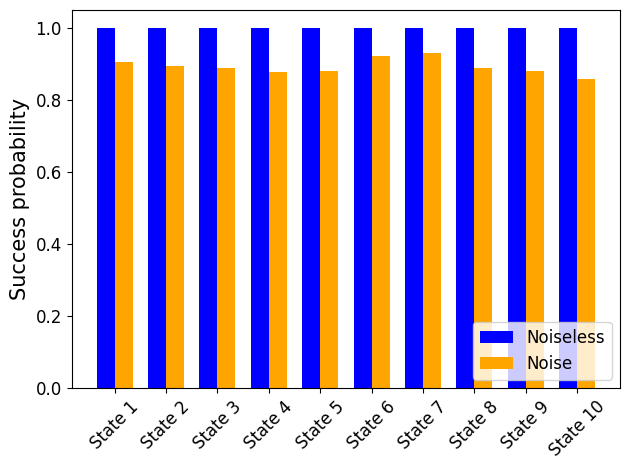

0.89267578125


In [15]:
states = list(probabilities_01.keys())
values1 = list(probabilities_01.values())
values2 = list(probabilities_02.values())
x = np.arange(len(states))  
width = 0.35

plt.bar(x - width/2, values2, width, label='Noiseless', color='blue')
plt.bar(x + width/2, values1, width, label='Noise', color='orange')

plt.ylabel("Success probability", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(x, states, rotation=45, fontsize=12)
plt.legend(loc="lower right",fontsize=12)
plt.tight_layout()
plt.show()

avg=0
for f in values1:
    avg+=f

avg=avg/10
print(avg)

Now, the next step is to analize more profoundly the performance of the circuit. We can model the probability of success as a function of the probability of an x gate happening, assuming there can only be one Z gate per qubit (with a total of 3) as:


$$
P(k) = \binom{3}{k} p_z^k (1 - p_z)^{3-k}
$$

where:
- $ k $ is the number of bit-flip errors (\(X\) gates).
- $ p_z $ is the probability of a phase-flip error occurring on a single qubit.
- $ \binom{3}{k} $ is the binomial coefficient, representing the number of ways to choose \( k \) qubits to have errors.

The total probability of success, $ P_{\text{total}} $, depends on the probability of success given that k errors occurred, denoted as $ P_k $:

$$
P_{\text{total}} = P_0 (1 - p_z)^3 + P_1 \cdot 3 p_z (1 - p_z)^2 + P_2 \cdot 3 p_z^2 (1 - p_z) + P_3 \cdot p_z^3
$$

where:
-  $P_0$  is the probability of success given that no errors occurred.
-  $P_1$  is the probability of success given that one qubit experienced an \(Z\) gate.
-  $P_2$  is the probability of success given that two qubits experienced an \(Z\) gate.
-  $P_3$ is the probability of success given that all three qubits experienced an \(Z\) gate.


Ideally,  $P_0 \approx 1$ (state remains unchanged) and $ P_1 \approx 1$  since a single bit-flip can be corrected.
In most cases,  $P_2 \approx 0$ and $P_3 \approx 0$  because two or three simultaneous bit-flips are not correctable using this correction circuit. 

Now, let´s use our model to study the difference between applying or not applying the circuit in the ideal case.


I have modified the original phaseflip error correction function to include four variables:
a, b and c take boolean values which represent if there is an additional x gate in the first, second or third qubit respectively. The parameter d is also a boolean, which if True it applies the correction circuit whereas if False it does not.


In [ ]:
def phaseflip_error_correction(psi, device_backend, d=False, a=False, b=False, c=False, noise_model=None, Nshots=1024, optim=0):
    qr = QuantumRegister(5, "q")
    cr_ancillas =ClassicalRegister(2, "c_ancillas")
    cr_main = ClassicalRegister(1, "c_main")  # For the first qubit
    qc = QuantumCircuit(qr,cr_ancillas , cr_main )

    init_gate = Initialize(psi)
    qc.append(init_gate, [0])

    qc.cx(0, 1)
    qc.cx(0, 2)

    qc.h(0)
    qc.h(1)
    qc.h(2)

    #The three additional inputs are to introduce z gates
    if a:
        qc.z(0) 
    if b:
        qc.z(1)  
    if c:
        qc.z(2)  
    
    qc.h(0)
    qc.h(1)
    qc.h(2)

    #Apply correction or not depending on d
    if d:
        qc.cx(0, 3)
        qc.cx(1, 3)
        qc.cx(1, 4)
        qc.cx(2, 4)
        qc.h(0)
        qc.h(1)
        qc.h(2)

        qc.measure(3, cr_ancillas[0])
        qc.measure(4, cr_ancillas[1])
        qc.z(0).c_if(cr_ancillas, 1)
        qc.z(1).c_if(cr_ancillas, 3)
        qc.z(2).c_if(cr_ancillas, 2)
    else:
        qc.h(0)
        qc.h(1)
        qc.h(2)

    qc.h(0)
    qc.h(1)
    qc.h(2)

    qc.cx(0, 2)
    qc.cx(0, 1)
    qc.append(init_gate.gates_to_uncompute(), [0])

    qc.measure(0, cr_main[0])  

    #display(qc.draw("mpl"))    #In case you want to check the layout

    qc_transpiled, counts = run_fake(qc, device_backend, noise_model, Nshots, optim)

    return qc_transpiled, counts

alpha=1/2
beta = np.sqrt(3)/2
psi=[alpha, beta]

qc_transpiled, counts = phaseflip_error_correction(psi, FakeBogotaV2(), d=True, a=False, b=True, c=False,  Nshots=1024, optim=0)
print(counts)

{'0 11': 1024}


I have created a function similar to evaluate_performance called evaluate_fidelity, which performs a similar action, but having as an output the total fidelity or probability of success (given the set of a, b, c and d) as well as its standard deviation from the mean as a measure of uncertainty. The other variable e, is also a boolean that states if there is noise (True) or not (False). I also stopped using the q_circuit variable since it was redundant.

In [88]:
def evaluate_fidelity(psi_list, e=False, d=False, a=False, b=False, c=False):
    num_trials = len(psi_list)
    all_counts = {}
    probabilities = {}
    probabilities_0 = {}

    for i, psi in enumerate(psi_list):
        _, counts = phaseflip_error_correction(psi, FakeVigoV2(), d=d, a=a, b=b, c=c, noise_model=e, Nshots=1024, optim=0)
        all_counts[f"State {i+1}"] = counts
        total_shots = sum(counts.values())

        state_probabilities = {}
        prob_0 = 0

        for outcome in counts:
            state_probabilities[outcome] = counts[outcome] / total_shots
            if outcome.startswith("0"):
                prob_0 += state_probabilities[outcome]

        probabilities[f"State {i+1}"] = state_probabilities
        probabilities_0[f"State {i+1}"] = prob_0

    fidelity = sum(probabilities_0.values()) / num_trials
    std_dev = np.std(list(probabilities_0.values()), ddof=1)
    uncertainty = std_dev / np.sqrt(num_trials)

    return fidelity, uncertainty

Below is a schematic of all of the possible cases we must analyze to evaluate the total performance:

1) NOISELESS (e=False):

A) No correction circuit (d=False):
- i) 0 gates (a=False, b=False, c=False)  
- ii) 1 gate (either a, b or c is True, the rest are False)  
- iii) 2 gates (two of a, b and c are True, the other is false)  
- iv) 3 gates (a=True, b=True, c=True)  

B) Correction circuit (d=True):
- i) 0 gates (a=False, b=False, c=False)  
- ii) 1 gate (either a, b or c is True, the rest are False)  
- iii) 2 gates (two of a, b and c are True, the other is false)  
- iv) 3 gates (a=True, b=True, c=True)  

2) NOISE(e=True):

A) No correction circuit (d=False) :
- i) 0 gates (a=False, b=False, c=False)  
- ii) 1 gate (either a, b or c is True, the rest are False)  
- iii) 2 gates (two of a, b and c are True, the other is false)  
- iv) 3 gates (a=True, b=True, c=True)  

B) Correction circuit (d=True):
- i) 0 gates (a=False, b=False, c=False)  
- ii) 1 gate (either a, b or c is True, the rest are False)  
- iii) 2 gates (two of a, b and c are True, the other is false)  
- iv) 3 gates (a=True, b=True, c=True)  


The following function calls evaluate_fidelity and computes the fidelity of all of the possible cases we have above, storing 

In [ ]:
def store_all_fidelities():
    results = {}
    booleans=[False, True]
    psi_list = [random_statevector(2) for _ in range(10)]   
    for e in booleans: 
        for d in booleans:  
            for num_z in range(4):  # 0, 1, 2, 3 Z gates
                fidelity_values = []
                uncertainty_values = []
                
                for z_comb in combinations(["a", "b", "c"], num_z): #Generates all possible combinations of num_x elements chosen from ["a", "b", "c"].If num_x=2, [("a", "b"), ("a", "c"), ("b", "c")]
                    
                    a, b, c = "a" in z_comb, "b" in z_comb, "c" in z_comb
                    fidelity, uncertainty = evaluate_fidelity(psi_list, a=a, b=b, c=c, d=d, e=e)
                    fidelity_values.append(fidelity)
                    uncertainty_values.append(uncertainty)
                
                fidelity_avg = float(np.mean(fidelity_values))
                
                uncertainty_avg = float(np.sqrt(np.sum(np.array(uncertainty_values) ** 2)) / len(uncertainty_values))
                
                results[f"Noise={e}, Correction={d}, Z Gates={num_z}"] = (fidelity_avg, uncertainty_avg)
    
    return results

results=store_all_fidelities()
print(results)

{'Noise=False, Correction=False, Z Gates=0': (1.0, 0.0), 'Noise=False, Correction=False, Z Gates=1': (0.7584635416666666, 0.03235843732900128), 'Noise=False, Correction=False, Z Gates=2': (0.51376953125, 0.04537477205222671), 'Noise=False, Correction=False, Z Gates=3': (0.2703125, 0.09505652012333451), 'Noise=False, Correction=True, Z Gates=0': (1.0, 0.0), 'Noise=False, Correction=True, Z Gates=1': (1.0, 0.0), 'Noise=False, Correction=True, Z Gates=2': (0.26901041666666664, 0.055533258414127845), 'Noise=False, Correction=True, Z Gates=3': (0.27041015625, 0.09612773511390915), 'Noise=True, Correction=False, Z Gates=0': (0.91845703125, 0.004013950392894626), 'Noise=True, Correction=False, Z Gates=1': (0.7094401041666667, 0.026538265478563233), 'Noise=True, Correction=False, Z Gates=2': (0.50546875, 0.03702540921541044), 'Noise=True, Correction=False, Z Gates=3': (0.29697265625, 0.07706288246842957), 'Noise=True, Correction=True, Z Gates=0': (0.83125, 0.009671639752681153), 'Noise=True, C

The next function simply extracts $P_0$ , $P_1$ , $P_2$ , $P_3$ from given values of e and d

In [90]:
def extract_success_probabilities(results, e, d):
    probabilities = [0] * 4  
    uncertainties= [0] *4
    for num_z in range(4):
        key = f"Noise={e}, Correction={d}, Z Gates={num_z}"
        if key in results:
            probabilities[num_z] = results[key][0]  
            uncertainties[num_z] = results[key][1]  
    
    return probabilities, uncertainties


With the funcions defined, we can start plotting. I have obtained error bars using propagation of error:
$$
\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x_1} \sigma_{x_1} \right)^2 + \left( \frac{\partial f}{\partial x_2} \sigma_{x_2} \right)^2 + \dots + \left( \frac{\partial f}{\partial x_n} \sigma_{x_n} \right)^2}
= \sqrt{(\sigma_{P_0} (1 - p_z)^3)^2 + (\sigma_{P_1} \cdot 3 p_z (1 - p_z)^2)^2 + (\sigma_{P_2} \cdot 3 p_z^2 (1 - p_z))^2 + (\sigma_{P_3} \cdot p_z^3)^2}
$$

The following one takes as input a pair of two booleans which represents two values of e and d, respectively. It will compare those two cases. For example, [(False, False), (True, False)], will compare the noise and noiseless (e=True and False) case of not applying the circuit (d=False).
It also takes as inputs results (needed for plotting) and the title and legend for plotting each case correctly. Note that, error bars have been reduced by a factor 10 for the results to be read more easily

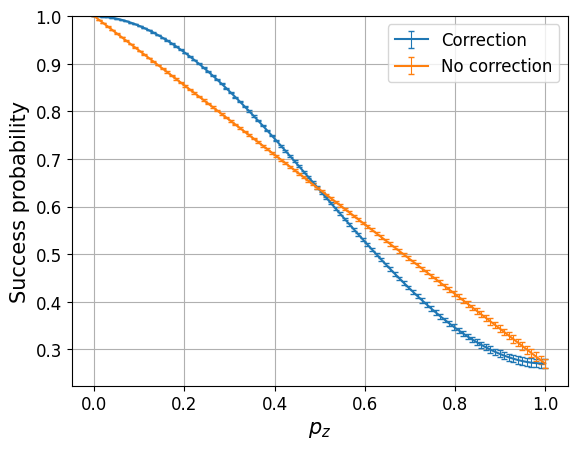

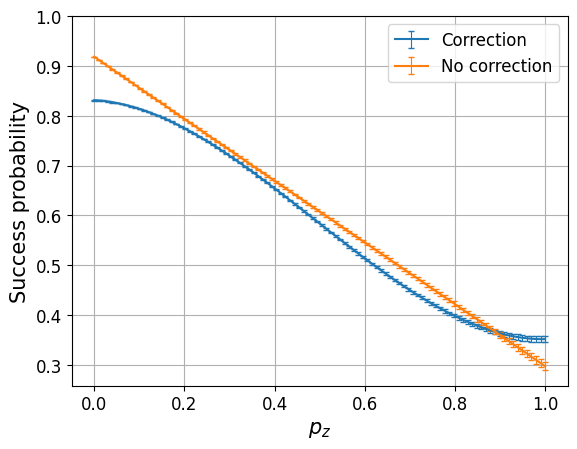

In [91]:
def plot_fidelity_curves(results, ed_pairs, title="Probability of success against probability of x gate", legend_labels=None):

    all_outputs = {}
    pz_values = np.linspace(0, 1, 100)
    for e, d in ed_pairs:
        probabilities, uncertainties = extract_success_probabilities(results, e, d)
    
        P_total_values = []
        P_total_uncertainties = []
        
        for pz in pz_values:
            P_total = probabilities[0] * (1 - pz) ** 3 + probabilities[1] * 3 * pz * (1 - pz) ** 2 + probabilities[2] * 3 * (pz ** 2) * (1 - pz) + probabilities[3] * (pz ** 3)
            P_uncertainty = np.sqrt((uncertainties[0] * (1 - pz) ** 3) ** 2 + (uncertainties[1] * 3 * pz * (1 - pz) ** 2) ** 2 + (uncertainties[2] * 3 * (pz ** 2) * (1 - pz)) ** 2 + (uncertainties[3] * (pz ** 3)) ** 2)
            
            P_total_values.append(P_total)
            P_total_uncertainties.append(P_uncertainty)
        
        P_total_uncertainties = np.array(P_total_uncertainties)
        all_outputs[(e, d)] = (np.array(P_total_values), np.array(P_total_uncertainties))
        plt.errorbar(pz_values, P_total_values, yerr=0.1  * P_total_uncertainties, fmt='-', elinewidth=0.8, capsize=2)

    plt.xlabel("$p_z$", fontsize=15)
    plt.ylabel("Success probability", fontsize=15)
    plt.ylim(top=1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(legend_labels, fontsize=12)
    plt.grid()
    plt.show()
    return pz_values, all_outputs

px, data1= plot_fidelity_curves(results, ed_pairs=[(False, True), (False, False)], title="Probabilities of success, noiseless",legend_labels=["Correction", "No correction"])
_, data2=plot_fidelity_curves(results, ed_pairs=[(True, True), (True, False)], title="Probabilities of success, noise",legend_labels=["Correction", "No correction"])

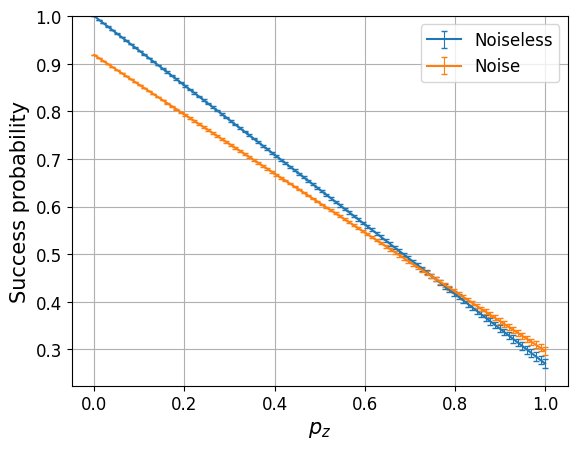

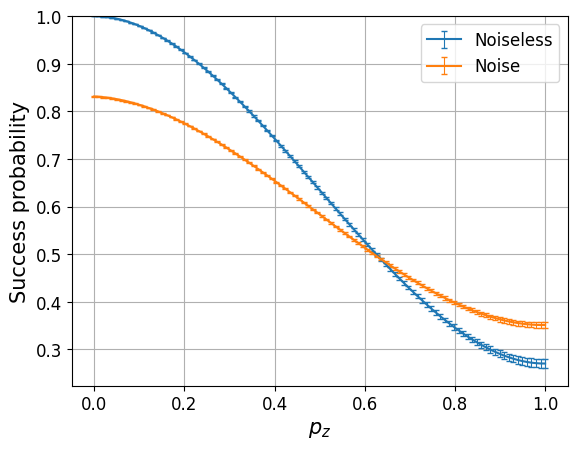

In [92]:
_, data3=plot_fidelity_curves(results, ed_pairs=[(False, False), (True, False)], title="Probabilities of success, no correction circuit",legend_labels=["Noiseless", "Noise"])

_, data4=plot_fidelity_curves(results, ed_pairs=[(False, True), (True, True)], title="Probabilities of success, correction circuit",legend_labels=["Noiseless", "Noise"])


In order to access the data itself we need to introduce data1,2,3 or 4and then the combination of booleans that makes up the graph itself. For example:

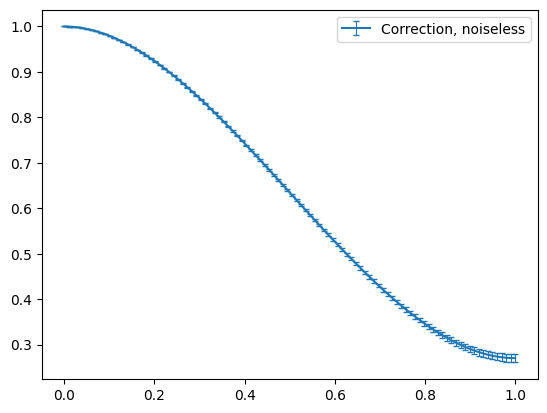

In [93]:
plt.errorbar(px, data1[(False, True)][0], yerr=0.1  * data1[(False, True)][1], fmt='-', elinewidth=0.8, capsize=2)
plt.legend(["Correction, noiseless"])
plt.show()

# 3 Tunable noise model implementation

First, I created a function that accepts a tunable noise model

In [94]:
def run_fake_my_noise(qc, device_backend, noise_model=None, Nshots=1024, optim=0):
 
    sim_faked = AerSimulator.from_backend(device_backend)
    qc_transpiled = transpile(qc, device_backend, optimization_level=optim)  
    result = sim_faked.run(qc_transpiled, shots=Nshots, noise_model=noise_model).result()
    counts = result.get_counts()

    return qc_transpiled, counts

This next functions only change to accept my noise model:

In [ ]:
def phaseflip_error_correction(psi, device_backend, d=False, a=False, b=False, c=False, noise_model=None, Nshots=1024, optim=0):
    qr = QuantumRegister(5, "q")
    cr_ancillas =ClassicalRegister(2, "c_ancillas")
    cr_main = ClassicalRegister(1, "c_main")  # For the first qubit
    qc = QuantumCircuit(qr,cr_ancillas , cr_main )

    init_gate = Initialize(psi)
    qc.append(init_gate, [0])

    qc.cx(0, 1)
    qc.cx(0, 2)

    qc.h(0)
    qc.h(1)
    qc.h(2)

    #The three additional inputs are to introduce z gates
    if a:
        qc.z(0) 
    if b:
        qc.z(1)  
    if c:
        qc.z(2)  

    
    #Apply correction or not depending on d
    if d:

        qc.h(0)
        qc.h(1)
        qc.h(2)
        
        qc.cx(0, 3)
        qc.cx(1, 3)
        qc.cx(1, 4)
        qc.cx(2, 4)

        qc.h(0)
        qc.h(1)
        qc.h(2)
        
        qc.measure(3, cr_ancillas[0])
        qc.measure(4, cr_ancillas[1])
        qc.z(0).c_if(cr_ancillas, 1)
        qc.z(1).c_if(cr_ancillas, 3)
        qc.z(2).c_if(cr_ancillas, 2)

    else:
        qc.h(0)
        qc.h(1)
        qc.h(2)

        qc.h(0)
        qc.h(1)
        qc.h(2)

    qc.h(0)
    qc.h(1)
    qc.h(2)

    qc.cx(0, 2)
    qc.cx(0, 1)
    qc.append(init_gate.gates_to_uncompute(), [0])

    qc.measure(0, cr_main[0])  

    #display(qc.draw("mpl"))    #In case you want to check the layout

    qc_transpiled, counts = run_fake_my_noise(qc, device_backend, noise_model, Nshots, optim)

    return qc_transpiled, counts

alpha = np.sqrt(0.5)
beta = np.sqrt(0.5)
psi=[alpha, beta]

qc_transpiled, counts = phaseflip_error_correction(psi, FakeBogotaV2(),d=False, Nshots=1024, optim=0)

In [96]:
def store_all_fidelities(noise_model):
    results = {}
    booleans = [False, True]
    psi_list = [random_statevector(2) for _ in range(10)]  

    for e in booleans:
        for d in booleans:
            for num_z in range(4):  # 0, 1, 2, 3 Z gates
                fidelity_values = []
                uncertainty_values = []

                for z_comb in combinations(["a", "b", "c"], num_z):
                    a, b, c = "a" in z_comb, "b" in z_comb, "c" in z_comb
                    if e==False:
                        fidelity, uncertainty = evaluate_fidelity(psi_list, a=a, b=b, c=c, d=d, e=None)
                    else:
                        fidelity, uncertainty = evaluate_fidelity(psi_list, a=a, b=b, c=c, d=d, e=noise_model)

                    fidelity_values.append(fidelity)
                    uncertainty_values.append(uncertainty)

                fidelity_avg = float(np.mean(fidelity_values))
                uncertainty_avg = float(np.sqrt(np.sum(np.array(uncertainty_values) ** 2)) / len(uncertainty_values))
                results[f"Noise={e}, Correction={d}, Z Gates={num_z}"] = (fidelity_avg, uncertainty_avg)

    return results

Function to test the performance only applying phase-flip error

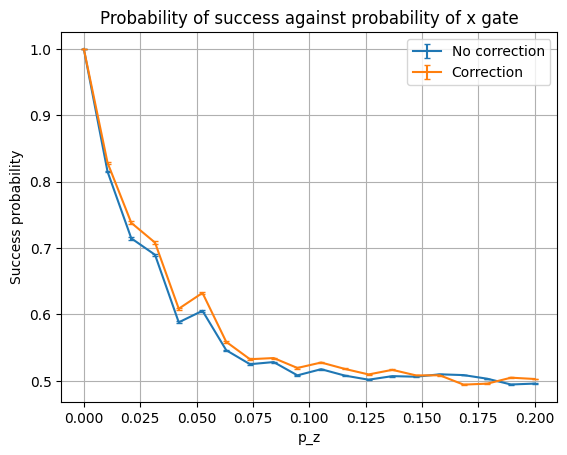

In [ ]:
def run_and_plot_fidelity_vs_pz_with_noise(p_meas, p_reset, num_trials=10, title="Probability of success against probability of z gate", legend_labels=None):
    all_outputs = {}
    booleans = [False, True]
    pz_values = np.linspace(0, 0.2, 20)

    for pz in pz_values:
        statevectors = [random_statevector(2) for _ in range(num_trials)]

        error_gate = pauli_error([("Z", pz), ("I", 1 - pz)])
        error_reset = pauli_error([("X", p_reset), ("I", 1 - p_reset)])
        error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_reset, "reset")
        noise_model.add_all_qubit_quantum_error(error_meas, "measure")
        noise_model.add_all_qubit_quantum_error(error_gate, ["u3", "rz", "sx", "id"])

        for i in booleans:
            if i not in all_outputs:
                all_outputs[i] = ([], [])

            fidelity, uncertainty = evaluate_fidelity(statevectors, e=noise_model, d=i)
            all_outputs[i][0].append(fidelity)
            all_outputs[i][1].append(uncertainty)

    for i in booleans:
        plt.errorbar(pz_values, all_outputs[i][0], yerr=0.1 * np.array(all_outputs[i][1]), fmt='-', capsize=2)

    plt.xlabel("p_z")
    plt.ylabel("Success probability")
    plt.title(title)
    plt.legend(legend_labels)
    plt.grid(True)
    plt.show()

    return pz_values, all_outputs


pz, alldata=run_and_plot_fidelity_vs_pz_with_noise(0, 0 , title="Probability of success against probability of z gate", legend_labels=["No correction", "Correction"])

Let us perform a study of how p_meas affects the outcome as well as pz:

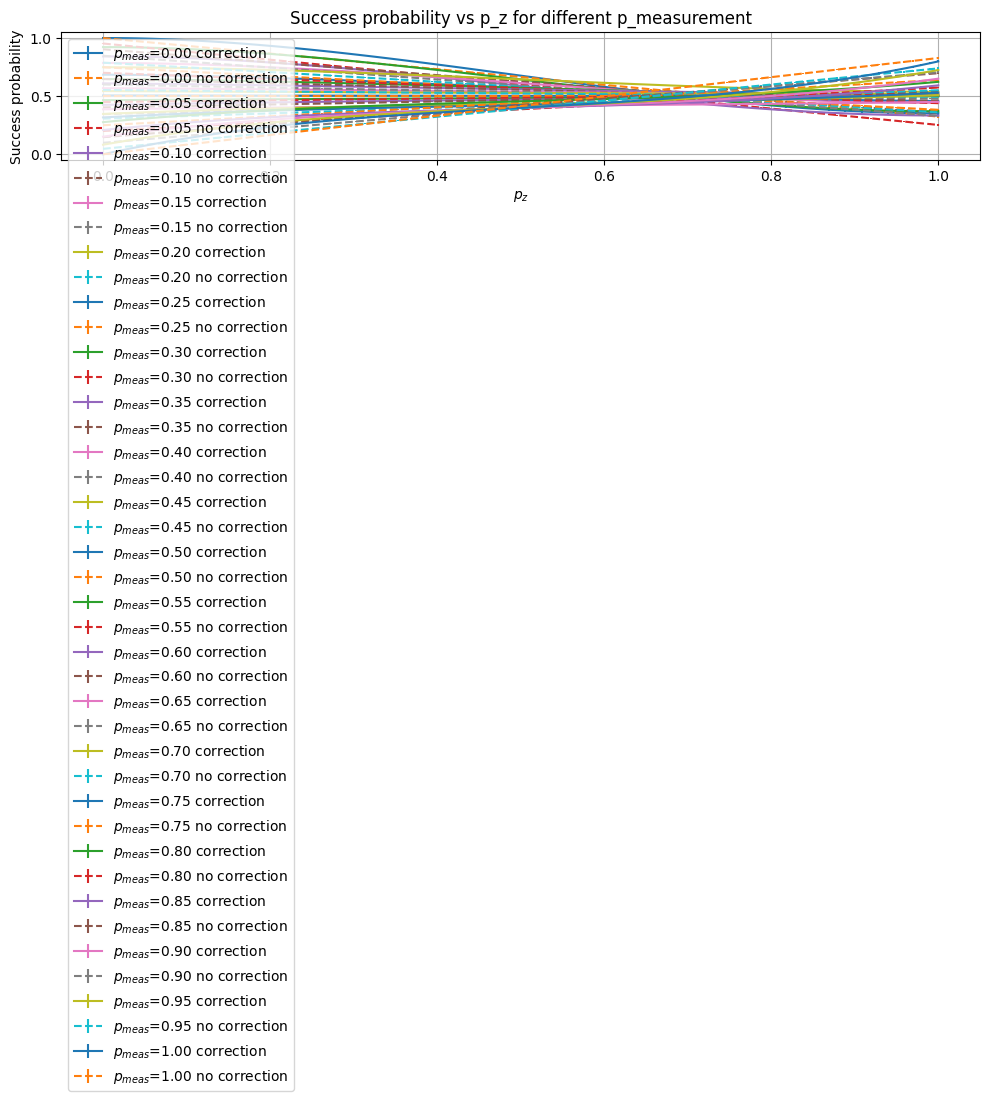

In [98]:
def plot_success_vs_pz_multiple_pmeas(pmeas_list, p_reset=0.0, p_z=0):
    plt.figure(figsize=(10, 7))
    pz_range = np.linspace(0, 1, 100)

    all_data = {} 

    for p_meas in pmeas_list:
        noise_model = NoiseModel()
        error_gate = pauli_error([("Z", p_z), ("I", 1 - p_z)])
        error_reset = pauli_error([("X", p_reset), ("I", 1 - p_reset)])
        error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])

        noise_model.add_all_qubit_quantum_error(error_reset, "reset")
        noise_model.add_all_qubit_quantum_error(error_meas, "measure")
        noise_model.add_all_qubit_quantum_error(error_gate, ["u3", "rz", "sx", "id"])

        for d_correction in [True, False]:
            results = store_all_fidelities(noise_model=noise_model)
            probs, uncerts = extract_success_probabilities(results, e=True, d=d_correction)

            success, uncert = [], []

            for px in pz_range:
                p0, p1, p2, p3 = probs
                u0, u1, u2, u3 = uncerts

                P = p0 * (1 - px) ** 3 + p1 * 3 * px * (1 - px) ** 2 + p2 * 3 * px ** 2 * (1 - px) + p3 * px ** 3
                U = np.sqrt(
                    (u0 * (1 - px) ** 3) ** 2 +
                    (u1 * 3 * px * (1 - px) ** 2) ** 2 +
                    (u2 * 3 * px ** 2 * (1 - px)) ** 2 +
                    (u3 * px ** 3) ** 2
                )
                success.append(P)
                uncert.append(U)

            label = f"$p_{{meas}}$={p_meas:.2f} {'correction' if d_correction else 'no correction'}"
            style = '-' if d_correction else '--'
            plt.errorbar(pz_range, success, yerr=0.1 * np.array(uncert), label=label, fmt=style)
            all_data[(p_meas, d_correction)] = {"pz": pz_range,"success": success,"uncertainty": uncert}

    plt.xlabel("$p_z$")
    plt.ylabel("Success probability")
    plt.title("Success probability vs p_z for different p_measurement")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return all_data

pmeas_list=[0,0.05, 0.1,0.15, 0.2,0.25,0.3,0.35,0.4,0.45, 0.5,0.55,0.6,0.65, 0.7,0.75, 0.8,0.85, 0.9,0.95, 1]
data123 = plot_success_vs_pz_multiple_pmeas(pmeas_list, p_reset=0.0)

In [99]:
pmeas0,pmeas1, pmeas2 = 0,0.5,1


info0 = data123[(pmeas0, True)]
info1 = data123[(pmeas1, True)]
info2 = data123[(pmeas2, True)]



info00 = data123[(pmeas0, False)]
info11 = data123[(pmeas1, False)]
info22 = data123[(pmeas2, False)]

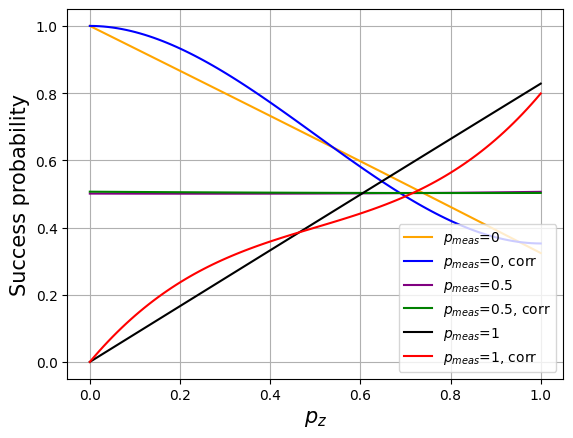

In [100]:

plt.plot(info00["pz"], info00["success"], label=f"$p_{{meas}}$={pmeas0}", color="orange")
plt.plot(info0["pz"], info0["success"], label=f"$p_{{meas}}$={pmeas0}, corr", color="blue")
plt.plot(info11["pz"], info11["success"], label=f"$p_{{meas}}$={pmeas1}", color="purple")
plt.plot(info1["pz"], info1["success"], label=f"$p_{{meas}}$={pmeas1}, corr", color="green")
plt.plot(info22["pz"], info22["success"], label=f"$p_{{meas}}$={pmeas2}", color="black")
plt.plot(info2["pz"], info2["success"], label=f"$p_{{meas}}$={pmeas2}, corr", color="red")



plt.xlabel("$p_z$",fontsize=15)
plt.ylabel("Success probability",fontsize=15)
plt.grid(True)
plt.legend(fontsize=10, loc='lower right')
plt.show()


Heatmap function

In [1]:
def plot_heatmap_success_from_data(all_data, pmeas_values, d=True):

    sample_entry = next(iter(all_data.values()))
    px_range = sample_entry["pz"]
    success_matrix = np.zeros((len(pmeas_values), len(px_range)))

    for i, p_meas in enumerate(pmeas_values):
        result = all_data.get((p_meas, d))
        if result:
            success_matrix[i, :] = result["success"]
        else:
            success_matrix[i, :] = np.nan

    plt.figure(figsize=(10, 6))
    extent = [px_range[0], px_range[-1], pmeas_values[0], pmeas_values[-1]]
    plt.imshow(success_matrix, extent=extent, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label="Success probability")

    plt.xlabel("$p_z$")
    plt.ylabel("$p_{meas}$")
    title = "Heatmap of success probability " + ("with correction" if d else "without correction")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap_success_from_data(data123, pmeas_list, d=True)
plot_heatmap_success_from_data(data123, pmeas_list, d=False)

NameError: name 'data123' is not defined

Heatmap differences

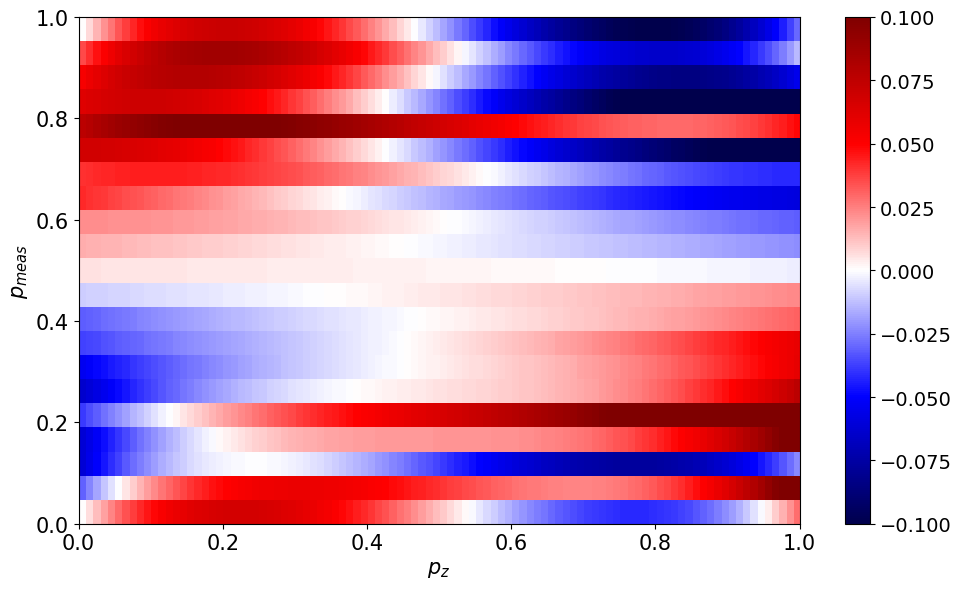

In [106]:
def plot_heatmap_difference(all_data, pmeas_values):
    sample_entry = next(iter(all_data.values()))
    px_range = sample_entry["pz"]

    matrix_corr = np.zeros((len(pmeas_values), len(px_range)))
    matrix_nocorr = np.zeros((len(pmeas_values), len(px_range)))

    for i, p_meas in enumerate(pmeas_values):
        res_corr = all_data.get((p_meas, True))
        res_nocorr = all_data.get((p_meas, False))

        if res_corr:
            matrix_corr[i, :] = res_corr["success"]
        else:
            matrix_corr[i, :] = np.nan

        if res_nocorr:
            matrix_nocorr[i, :] = res_nocorr["success"]
        else:
            matrix_nocorr[i, :] = np.nan

    matrix_diff = matrix_corr - matrix_nocorr

    plt.figure(figsize=(10, 6))
    extent = [px_range[0], px_range[-1], pmeas_values[0], pmeas_values[-1]]
    im = plt.imshow(matrix_diff, extent=extent, aspect='auto', origin='lower', cmap='seismic', vmin=-0.1, vmax=0.1)
    cbar=plt.colorbar(im)
    cbar.ax.tick_params(labelsize=14)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
  

    plt.xlabel("$p_z$", fontsize=15)
    plt.ylabel("$p_{meas}$", fontsize=15)
    plt.tight_layout()
    plt.show()

plot_heatmap_difference(data123, pmeas_list)
